## Installing Libraries

In [ ]:
pip install sentencepiece

     |████████████████████████████████| 1.1MB 13.7MB/s 


In [ ]:
!pip3 install fastai=='1.0.60'

     |████████████████████████████████| 245kB 9.3MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
!pip3 install torch=='1.1.0'

     |████████████████████████████████| 676.9MB 25kB/s 
ERROR: torchvision 0.6.0+cu101 has requirement torch==1.5.0, but you'll have torch 1.1.0 which is incompatible.
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101


# Importing Libraries

In [ ]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [ ]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.60', '1.1.0')

# Fetching Training and Validation Data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Fetching Training Data

In [ ]:
path_train_dataset = '/content/drive/My Drive/marathi-news-dataset/train.csv'
train_df = pd.read_csv(path_train_dataset)
train_df.head()

,headline,label
0,सचिन तेंडुलकरने बाळासाहेबांच्या आठवणींना दिला ...,state
1,"बहुजन वंचित आघाडीची पहिली यादी जाहीर, प्रकाश आ...",state
2,"गृहमंत्रिपद हे पार्ट टाइम नाही, राजीनामा द्या,...",state
3,पुण्यात आघाडीचा पोपट पुन्हा जिवंत !,state
4,शरद पवार यांनी मिलिंद नार्वेकर यांच्या कानात क...,state


In [ ]:
print('In Training data:')
for category in train_df['label'].unique():
  print(category, (train_df['label'] == category).sum())

In Training data:
state 6035
entertainment 2644
sports 994


### Fetching Validation Data

In [ ]:
path_valid_dataset = '/content/drive/My Drive/marathi-news-dataset/valid.csv'
valid_df = pd.read_csv(path_valid_dataset)
valid_df.head()

,headline,label
0,पहाटे 3:30 वाजता बीग बींनी गायल 'हे' रॅप साँग,entertainment
1,राष्ट्रपती आणि पंतप्रधानांनी वाहिली श्रीदेवींन...,entertainment
2,सायरा बानोंना जागेसाठी धमकावणाऱ्या बिल्डराविरो...,entertainment
3,"मुंबईत पहिल्यांदाच पन्नाशी पार, राज्यात सरासरी...",state
4,अण्णांची मनधरणी करण्यासाठी गिरीश महाजन राळेगणस...,state


In [ ]:
print('In Validation data:')
for category in valid_df['label'].unique():
  print(category, (valid_df['label'] == category).sum())

In Validation data:
entertainment 679
state 1512
sports 228


# Building Marathi Language Model

In [ ]:
label_cols = list(range(1,train_df.shape[1]))

In [ ]:
id_to_col = list(train_df.columns)

In [ ]:
col_to_id = {}
for i, col in enumerate(id_to_col):
    col_to_id[col] = i

In [ ]:
class MarathiTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str("/content/drive/My Drive/NLP Marathi/marathi_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [ ]:
sp = spm.SentencePieceProcessor()
sp.Load(str("/content/drive/My Drive/NLP Marathi/marathi_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(30000)]

In [ ]:
itos[:10]

['<unk>', '<s>', '</s>', '.', '▁', ',', '▁आहे', '▁·', '▁या', '▁व']

In [ ]:
marathi_vocab = Vocab(itos)

In [ ]:
tokenizer = Tokenizer(tok_func=MarathiTokenizer, lang='mr')

In [ ]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [ ]:
data_lm = TextLMDataBunch.from_df(path="/content/drive/My Drive/NLP Marathi/", train_df=train_df, valid_df=valid_df, text_cols=[0], label_cols=label_cols, tokenizer=tokenizer, vocab=marathi_vocab, bs=16)

In [ ]:
data_lm.save()

In [ ]:
data_lm.show_batch()

idx,text
0,x bo s ▁शरद ▁पवार ▁यांनी ▁मिलिंद ▁नार ्वे कर ▁यांच्या ▁कानात ▁काय ▁सांगितलं ▁असेल ? ▁x x bo s ▁ग्रेट ▁भेट मध्ये ▁अंजली ▁भागवत ▁- ▁भाग ▁3 ▁x x bo s ▁' तारक ▁मेहता . . ' चा ▁कलाकार ▁विशाल ▁ठ क्कर ▁11 ▁दिवस ांपासून ▁बे पत्ता ▁x x bo s ▁' द ंगल ' मुळे ▁ स्मा ॅल ▁स्क्रीन ▁थिएटर ्स ला ▁फायदा ▁x x bo s ▁चाह
1,"▁पंजाब चा ▁दिल्लीवर ▁ दणदणीत ▁विजय ▁x x bo s ▁सलमान सोबत ▁कुठली ▁अभिनेत्री ▁करणार ▁' बी ग ▁बॉस ' चं ▁अँ कर ींग ? ▁x x bo s ▁' नो ▁ हेल्म ेट - नो ▁पेट्रोल ' ला ▁पुणेकर ांचा ▁विरोध , ▁पेट्रोल ▁पंप ▁संघटनेचा ही ▁बंद चा ▁इशारा ▁x x bo s ▁कोलकाता ▁ नाईट ▁रायडर्स कडून ▁राजस्थान ▁रॉयल्स चा ▁6 ▁गडी ▁राखून ▁पराभव ▁x x bo s"
2,"▁' मैदान - ए - जंग ' ▁! ▁x x bo s ▁' महाराष्ट्र ▁रज नी ' ▁चुकीच्या ▁ठिकाणी च ▁! , ▁आग ▁व िझ ली ▁आता ▁राजकारण ▁पेट लं ▁x x bo s ▁ <unk> ▁बाप्पा मोर या रे ▁: ▁अंबा नी ंच्या ▁घरच्या ▁गणपती ला ▁ लोट लं ▁बा ॅल ि वूड ▁x x bo s ▁' आ धार ▁कार्ड ' ची ▁नोंदणी ▁आता ▁गॅस ▁वि तर क"
3,"▁' फ िक्स ' ▁x x bo s ▁ऑपरेशन ▁' नगर ' ▁नंतर ▁हे ▁आहे ▁भाजप चं ▁पुढ चं ▁लक्ष्य ▁x x bo s ▁माझ्या विरोधात ▁कट ात ▁पक्ष ातील ▁विरोधक ▁सहभागी - खड से ▁x x bo s ▁आमदार ▁बच्च ू ▁कडू ▁यांना ▁अचल पूर ▁कोर्ट ाकडून ▁7 ▁महिन्यां ची ▁शिक्षा ▁x x bo s ▁राज्यात ▁डान्स ▁बार ▁पुन्हा ▁सुरू ▁होणार , ▁सुप्री म ▁कोर्ट ाने ▁दिला ▁मोठा ▁निर्णय"
4,"▁सहभाग ामुळे ▁अशी ▁बदल तील ▁समीकरण ं ▁x x bo s <unk> ▁v <unk> id e o ▁: गु हा गर मध्ये ▁समुद्र ातून ▁आलेली ▁महाकाय ▁मग र ▁येत ▁होती ▁वस्ती कडे ▁पण . . . ▁x x bo s ▁आमीर ▁खान ने ▁घेतली ▁अण्णां ची ▁भेट ▁x x bo s ▁राजू ▁शेट्टी ही ▁आता ▁देणार ▁पवार ांना ▁आव्हान , ▁' स ्वा भिमान ी ' चा ▁ठराव ▁मंजूर ▁x"


# Training Classifier Model

In [ ]:
awd_lstm_config = awd_lstm_lm_config.copy()
awd_lstm_config['n_hid'] = 1150
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3, config=awd_lstm_config, pretrained=False)

In [ ]:
learn.load('/content/drive/My Drive/NLP Marathi/fourth_mr_lm', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (9673 items)
x: LMTextList
▁x x bo s ▁सचिन ▁तेंडुलकर ने ▁बाळासाहेब ांच्या ▁आठवणी ंना ▁दिला ▁उ जाळ ा,▁x x bo s ▁बहुजन ▁वंचित ▁आघाडी ची ▁पहिली ▁यादी ▁जाहीर , ▁प्रकाश ▁आंबेडकरांच्या ▁मतदारसंघ ावरुन ▁स स्पे ं न्स ▁कायम,▁x x bo s ▁गृह मंत्रिपद ▁हे ▁पार्ट ▁टाइम ▁नाही , ▁राजीनामा ▁द्या , ▁ तृप्त ी ▁देसाई ंची ▁मुख्यमंत्र्या ंवर ▁टीका,▁x x bo s ▁पुण्यात ▁आघाडी चा ▁पोपट ▁पुन्हा ▁जिवंत ▁!,▁x x bo s ▁शरद ▁पवार ▁यांनी ▁मिलिंद ▁नार ्वे कर ▁यांच्या ▁कानात ▁काय ▁सांगितलं ▁असेल ?
y: LMLabelList
,,,,
Path: /content/drive/My Drive/NLP Marathi;

Valid: LabelList (2419 items)
x: LMTextList
▁x x bo s ▁पहाटे ▁3 : 30 ▁वाजता ▁बी ग ▁बी ंनी ▁गाय ल ▁' हे ' ▁रॅप ▁स ाँग,▁x x bo s ▁राष्ट्रपती ▁आणि ▁पंतप्रधान ांनी ▁वाहिली ▁श्री देवी ंना ▁श्रद्धांजली,▁x x bo s ▁साय रा ▁बा नो ंना ▁जागे साठी ▁धमकाव णाऱ्या ▁बिल्डर ाविरोधात ▁गुन्हा ▁दाखल,▁x x bo s ▁मुंबईत ▁पहिल्यांदाच ▁पन्ना शी ▁पार , ▁राज्यात ▁सरासरी ▁55 ▁टक्के ▁मतदान,▁x x bo s ▁अण्णां ची ▁मन धरण ी ▁करण्यासाठी ▁गिरी

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


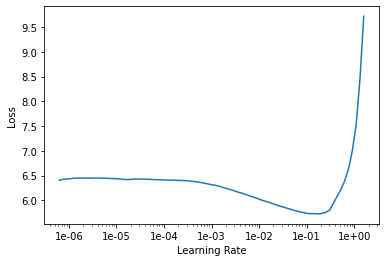

In [ ]:
learn.recorder.plot()

In [ ]:
learn.freeze()

In [ ]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.843278,4.582155,0.347276,00:13


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.203562,4.363638,0.368979,00:14
1,3.938712,4.175129,0.390728,00:14
2,3.613247,4.117294,0.399954,00:14
3,3.314277,4.116832,0.402701,00:14
4,3.155169,4.136128,0.402610,00:14


In [ ]:
learn.predict('सीमा भागातील मराठी',n_words=10)

'सीमा भागातील मराठी ▁शिक ाव णार ▁भाजप साठी ▁तुम्ही ही ▁अब स ▁दै'

In [ ]:
learn.save_encoder('fine_tuned_enc')

In [ ]:
data_clas = TextClasDataBunch.from_df(path="/content/drive/My Drive/NLP Marathi/", train_df=train_df, valid_df=valid_df, tokenizer=tokenizer, vocab=marathi_vocab, text_cols=[0], label_cols=label_cols, bs=16)

In [ ]:
data_clas.show_batch()

text,target
"▁x x bo s <unk> ▁l ive ▁cricket <unk> <unk> co re , <unk> ▁v s <unk> ▁2 nd ▁test , ▁4 th ▁ <unk> day - ▁ल ंच नंतर ▁ऑस्ट्रेलिया ला ▁दोन ▁धक्के , ▁शमी ने च ▁घेतल्या ▁दोन्ही ▁विकेट , ▁पेन - ▁फिंच ▁बाद",sports
"▁x x bo s <unk> ▁l ive ▁cricket <unk> <unk> co re , <unk> ▁v s <unk> ▁2 nd ▁test , ▁4 th ▁ <unk> day - ▁ऑस्ट्रेलिया ▁२४ ३ ▁वर ▁ऑल - ▁ आऊट , ▁भारत ासमोर ▁२८ ६ ▁धावा ंचं ▁लक्ष्य",sports
"▁x x bo s <unk> ▁b hi wan di , <unk> ve l , ▁ma le ga on <unk> ect ion ▁re s ul ts ▁2017 <unk> ▁l ive ▁: ▁पनवेल मध्ये ▁भाजप ▁तर ▁भिवंडी - माल ेगाव मध्ये ▁काँग्रेस ▁!",state
"▁x x bo s <unk> ▁l ive ▁cricket <unk> <unk> co re , <unk> ▁v s <unk> ▁1 st ▁test , ▁3 rd ▁ <unk> day , ▁ऑस्ट्रेलिया ▁ २३५ ▁ला ▁ऑ ला ▁ आऊट , ▁मात्र ▁पुन्हा ▁सुरू ▁झाला ▁पाऊस",sports
▁x x bo s <unk> ▁v <unk> id e o ▁: ▁x x re p ▁4 ▁ . ▁आणि ▁हा ▁' ब च्च ू ' ▁पोह ायला ▁लागला ; ▁कासव ावर ही ▁ फिज िओ थेर पी ची ▁जादू,state


In [ ]:
del awd_lstm_config['tie_weights']
del awd_lstm_config['out_bias']

In [ ]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5, config=awd_lstm_config)

In [ ]:
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (9673 items)
x: TextList
▁x x bo s ▁सचिन ▁तेंडुलकर ने ▁बाळासाहेब ांच्या ▁आठवणी ंना ▁दिला ▁उ जाळ ा,▁x x bo s ▁बहुजन ▁वंचित ▁आघाडी ची ▁पहिली ▁यादी ▁जाहीर , ▁प्रकाश ▁आंबेडकरांच्या ▁मतदारसंघ ावरुन ▁स स्पे ं न्स ▁कायम,▁x x bo s ▁गृह मंत्रिपद ▁हे ▁पार्ट ▁टाइम ▁नाही , ▁राजीनामा ▁द्या , ▁ तृप्त ी ▁देसाई ंची ▁मुख्यमंत्र्या ंवर ▁टीका,▁x x bo s ▁पुण्यात ▁आघाडी चा ▁पोपट ▁पुन्हा ▁जिवंत ▁!,▁x x bo s ▁शरद ▁पवार ▁यांनी ▁मिलिंद ▁नार ्वे कर ▁यांच्या ▁कानात ▁काय ▁सांगितलं ▁असेल ?
y: CategoryList
state,state,state,state,state
Path: /content/drive/My Drive/NLP Marathi;

Valid: LabelList (2419 items)
x: TextList
▁x x bo s ▁पहाटे ▁3 : 30 ▁वाजता ▁बी ग ▁बी ंनी ▁गाय ल ▁' हे ' ▁रॅप ▁स ाँग,▁x x bo s ▁राष्ट्रपती ▁आणि ▁पंतप्रधान ांनी ▁वाहिली ▁श्री देवी ंना ▁श्रद्धांजली,▁x x bo s ▁साय रा ▁बा नो ंना ▁जागे साठी ▁धमकाव णाऱ्या ▁बिल्डर ाविरोधात ▁गुन्हा ▁दाखल,▁x x bo s ▁मुंबईत ▁पहिल्यांदाच ▁पन्ना शी ▁पार , ▁राज्यात ▁सरासरी ▁55 ▁टक्के ▁मतदान,▁x x bo s ▁अण्णां ची ▁मन धरण 

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


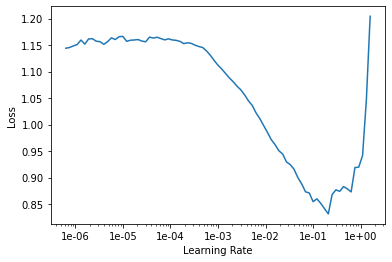

In [ ]:
learn.recorder.plot()

In [ ]:
learn.loss_func.func

CrossEntropyLoss()

In [ ]:
kappa = KappaScore()

In [ ]:
learn.metrics = [kappa, accuracy]

In [ ]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.412188,0.311331,0.767002,0.881356,00:12


In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.324208,0.241747,0.832640,0.912774,00:14


In [ ]:
learn.save('second-full')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='final')])

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.071508,0.243824,0.860956,0.927243,00:20
1,0.100259,0.258941,0.854633,0.923936,00:21
2,0.049592,0.246790,0.861821,0.928483,00:21
3,0.026989,0.255958,0.864093,0.928896,00:22
4,0.016860,0.246166,0.862669,0.928483,00:22


Better model found at epoch 0 with accuracy value: 0.927242636680603.
Better model found at epoch 2 with accuracy value: 0.9284828305244446.
Better model found at epoch 3 with accuracy value: 0.9288962483406067.


# Loading Classifier Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
train_df = pd.read_csv('/content/drive/My Drive/marathi-news-dataset/train.csv')
valid_df = pd.read_csv('/content/drive/My Drive/marathi-news-dataset/valid.csv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
class MarathiTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str("/content/drive/My Drive/NLP Marathi/marathi_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

tokenizer = Tokenizer(tok_func=MarathiTokenizer, lang='mr')

In [ ]:
sp = spm.SentencePieceProcessor()
sp.Load(str("/content/drive/My Drive/NLP Marathi/marathi_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(30000)]
marathi_vocab = Vocab(itos)

In [ ]:
label_cols = list(range(1,train_df.shape[1]))
data_lm = TextLMDataBunch.from_df(path="/content/drive/My Drive/NLP Marathi/", train_df=train_df, valid_df=valid_df, text_cols=[0], label_cols=label_cols, tokenizer=tokenizer, vocab=marathi_vocab, bs=16)
awd_lstm_config = awd_lstm_lm_config.copy()
awd_lstm_config['n_hid'] = 1150
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3, config=awd_lstm_config, pretrained=False)

In [ ]:
data_clas = TextClasDataBunch.from_df(path="/content/drive/My Drive/NLP Marathi/", train_df=train_df, valid_df=valid_df, tokenizer=tokenizer, vocab=marathi_vocab, text_cols=[0], label_cols=label_cols, bs=16)
del awd_lstm_config['tie_weights']
del awd_lstm_config['out_bias']
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5, config=awd_lstm_config)

In [ ]:
learn.load('/content/drive/My Drive/NLP Marathi/models/final-model')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (9673 items)
x: TextList
▁x x bo s ▁सचिन ▁तेंडुलकर ने ▁बाळासाहेब ांच्या ▁आठवणी ंना ▁दिला ▁उ जाळ ा,▁x x bo s ▁बहुजन ▁वंचित ▁आघाडी ची ▁पहिली ▁यादी ▁जाहीर , ▁प्रकाश ▁आंबेडकरांच्या ▁मतदारसंघ ावरुन ▁स स्पे ं न्स ▁कायम,▁x x bo s ▁गृह मंत्रिपद ▁हे ▁पार्ट ▁टाइम ▁नाही , ▁राजीनामा ▁द्या , ▁ तृप्त ी ▁देसाई ंची ▁मुख्यमंत्र्या ंवर ▁टीका,▁x x bo s ▁पुण्यात ▁आघाडी चा ▁पोपट ▁पुन्हा ▁जिवंत ▁!,▁x x bo s ▁शरद ▁पवार ▁यांनी ▁मिलिंद ▁नार ्वे कर ▁यांच्या ▁कानात ▁काय ▁सांगितलं ▁असेल ?
y: CategoryList
state,state,state,state,state
Path: /content/drive/My Drive/NLP Marathi;

Valid: LabelList (2419 items)
x: TextList
▁x x bo s ▁पहाटे ▁3 : 30 ▁वाजता ▁बी ग ▁बी ंनी ▁गाय ल ▁' हे ' ▁रॅप ▁स ाँग,▁x x bo s ▁राष्ट्रपती ▁आणि ▁पंतप्रधान ांनी ▁वाहिली ▁श्री देवी ंना ▁श्रद्धांजली,▁x x bo s ▁साय रा ▁बा नो ंना ▁जागे साठी ▁धमकाव णाऱ्या ▁बिल्डर ाविरोधात ▁गुन्हा ▁दाखल,▁x x bo s ▁मुंबईत ▁पहिल्यांदाच ▁पन्ना शी ▁पार , ▁राज्यात ▁सरासरी ▁55 ▁टक्के ▁मतदान,▁x x bo s ▁अण्णां ची ▁मन धरण 

# **RESULTANT TEXT CLASSIFIER**

In [ ]:
#@title Type an Input Sentence { display-mode: "form" }

Sentence = "\u0915\u0939\u0940\u0902 \u0926\u0942\u0930 \u091C\u092C \u0926\u093F\u0928 \u0922\u0932 \u091C\u093E\u090F.... \u092F\u093E\u0902\u0938\u093E\u0930\u0916\u094D\u092F\u093E \u0938\u0926\u093E\u092C\u0939\u093E\u0930 \u0917\u093E\u0923\u094D\u092F\u093E\u0902\u091A\u0947 \u0917\u0940\u0924\u0915\u093E\u0930 \u092F\u094B\u0917\u0947\u0936 \u092F\u093E\u0902\u091A\u0902 \u0928\u093F\u0927\u0928" #@param {type:"string"}
print("Prediction:")
print(learn.predict(Sentence))

Prediction:
(Category entertainment, tensor(0), tensor([0.7706, 0.0031, 0.2262]))


# Accuracy Score, Confusion Matrix & Classification Matrix

In [ ]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import seaborn as sns

In [ ]:
x_train = train_df['headline'].values
y_train = train_df['label'].values
x_test = valid_df['headline'].values
y_test = valid_df['label'].values

In [ ]:
predictions = []
for i in range (0,len(x_test)):
  prediction = learn.predict(x_test[i])
  predictions.append(str(prediction[0]))

## Accuracy Score

In [ ]:
print ('Accuracy Score:',accuracy_score(y_test, predictions))

Accuracy Score: 0.9359239355105415


## Confusion Matrix

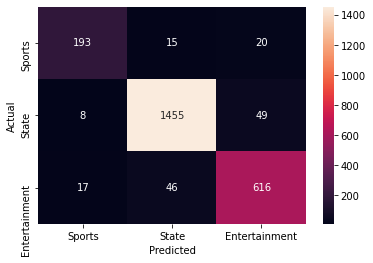

In [ ]:
cf_matrix = confusion_matrix(y_test, predictions, labels=['sports','state','entertainment'])
sns.heatmap(cf_matrix, annot=True, fmt='', xticklabels=['Sports','State','Entertainment'], yticklabels=['Sports','State','Entertainment'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Classification Report

In [ ]:
print('Classification Report:')
print (classification_report(y_test, predictions))

Classification Report:
               precision    recall  f1-score   support

entertainment       0.90      0.91      0.90       679
       sports       0.89      0.85      0.87       228
        state       0.96      0.96      0.96      1512

     accuracy                           0.94      2419
    macro avg       0.91      0.91      0.91      2419
 weighted avg       0.94      0.94      0.94      2419

